# Immune Receptor Preprocessing

### Chapter Goals:
- Understanding output of allignment pipelines
- Allingning into cell-based format
- Asssignment of IR state


### Content:
1. Intro Immune Receptor Profiling
2. Dataset
3. Loading Data
    1. Understanding Raw Data
    2. Sort to cell format
4. Assign IR state
    1. Single Chains
    2. Multiple IRs


## 1. Introduction: Immune Receptor Profiling

- **Role IR in cells => highly polymorphic immune receptors (IR) in from of TCR and BCR**

Immune Receptors (IR) are the key for the recognition of potential hazardous antigens and toxins invading the body. Those receptors are usually located in the membrane of speciallized cells on charge of recognized and carry out the protective work. There are different kinds of IRs speciallized in the recognition of specific structures from the forainer agent:

        - Pattern recognition receptors (PRRs) ==> Pathogen-associated molecular patterns (PAMPS)
        - Killer activator/inhibitor receptors (KARs/KIRs) ==> Host cells abnormalities
        - Complement receptors ==> Complement proteins
        - Fc receptors ==> Epitope-antibody complex
        - B-cell receptor (BCRs) ==> Epitopes
        - T-cell recpetors (TCRs) ==> Linear epitopes bound to major histocompatibility complex (MHC)
        - Cytokine receptors ==> Cytokines

There are two major linage of cells with IR known as lymphocytes wich are produced in the Thymus and Bone-marrow called T- and B-cells [1]. 

- **TCR interacts with pMHC to detect pathogens and external entities**

Those major linages do not work separately. Otherwise, the act in a interoperate manner. In the case of T-cells, they used the TCRs to recognized key surface molecules encoded by the major histocompatibility complex (MHC) genes on antigen presenter cells such as Dendritic cells or B-cells [1].

- **BCR binds to free stuff**

As described above, B-cells are antigen presenter cells, it means the B-cells receptors (BCRs) recognized specififc and intact molcules from the antigen.

- **Composition of IR via VDJ**

    - two chains (TCR: majoriy alpha/beta some gamma/delta (innate like) (BCR: 
    - Variable diversity joining segments
    - VJ = light chain, TRA
    - VDJ = heavy chain, TRB
    - Formation via recombination process => combinatorial diversity + junctional (?) diversity (TCR)
    - Large diversity => detection of various disease / autoimmunity 
    - Complmentary Determining region 1-3 most variable => CDR3 main for binding
    
- **Adaptive immune repertoire sequencing**

    - Single-cell isolation:
    
        - Flow-cytrometry
        - Microfluidic devices
        - Microwell plates
        
    - Single-cell library preparation:
    
        - Droplets with unique barcodes
        - Emultion with magnetic beads [2]
        
[1] Cooper, M. D., & Alder, M. N. (2006). The evolution of adaptive immune systems. Cell, 124(4), 815-822.

[2] Liu, H., Pan, W., Tang, C., Tang, Y., Wu, H., Yoshimura, A., ... & Li, S. (2021). The methods and advances of adaptive immune receptors repertoire sequencing. Theranostics, 11(18), 8945.

## 2. Dataset

To showcase different approaches for preprocessing and analysis of IRs, we will use the dataset published by the Haniffa Lab (Stepenson et al, [1]), which contains transcriptome sequencing for over 750,000 Peripheral Blood Mononuclear Cells (PBMC) from 130 patients in the context of Severe Acute Respiratory Syndrome Coronavirus 2 (SARS-CoV-2).

It consists of patients from three sources (Newcastle, Cambridge, and London) with different degrees of severity (assymptomatic, mild, mederate, severe, and critical) as well as negative controls (healthy, other severe respiratory illnesses, and healthy with Intravenous Liposaccharide to mimic systemic inflammatory response). Additional, patient-level information such as age span, gender, and smoker status are provided. 

The dataset was choosen as an expample of a large-scale single cell dataset including VDJ-Sequencing, that is well known to the community. It contains over 150,000 B-Cells and 200,000 T-Cells with IR annotation, that we will regard in this analysis tutorial.

To download the data please run the following commands:

```
wget https://www.ebi.ac.uk/arrayexpress/files/E-MTAB-10026/E-MTAB-10026.processed.1.zip
unzip E-MTAB-10026.processed.1.zip

wget https://www.ebi.ac.uk/arrayexpress/files/E-MTAB-10026/E-MTAB-10026.processed.2.zip
unzip E-MTAB-10026.processed.2.zip
```

Or download and unzip from:
- https://www.ebi.ac.uk/arrayexpress/files/E-MTAB-10026/E-MTAB-10026.processed.1.zip
- https://www.ebi.ac.uk/arrayexpress/files/E-MTAB-10026/E-MTAB-10026.processed.2.zip

[1] Stephenson, E., Reynolds, G., Botting, R.A. et al. Single-cell multi-omics analysis of the immune response in COVID-19. Nat Med 27, 904–916 (2021). https://doi.org/10.1038/s41591-021-01329-2

## 3. Load data
In this tutorial we will mainly use 2 python packages for loading, allignment?, and visualiation
- Scanpy: general package for single cell analysis (https://github.com/theislab/scanpy, [2])
- Scirpy: scanpy extension for immune receptor analysis (https://github.com/scverse/scirpy, [3])

Further, we use additional python packages commonly used for data handling, processing, and visualisation.

<br />
<br />
[2] Wolf, F., Angerer, P. & Theis, F. SCANPY: large-scale single-cell gene expression data analysis. Genome Biol 19, 15 (2018). https://doi.org/10.1186/s13059-017-1382-0

[3] Gregor Sturm, Tamas Szabo, Georgios Fotakis, Marlene Haider, Dietmar Rieder, Zlatko Trajanoski, Francesca Finotello, Scirpy: a Scanpy extension for analyzing single-cell T-cell receptor-sequencing data, Bioinformatics, Volume 36, Issue 18, 15 September 2020, Pages 4817–4818, https://doi.org/10.1093/bioinformatics/btaa611

In [1]:
import scanpy as sc
import scirpy as ir

import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt

C:\Users\felix.drost\AppData\Roaming\Python\Python37\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Let's set the input and output paths of our data.

In [2]:
path_data = '../data'

path_bcr_input = f'{path_data}/scbcr_cellranger_filtered_contig_annotations.csv.gz'
path_tcr_input = f'{path_data}/TCR_merged-Updated.tsv'
path_tcr_csv = f'{path_data}/TCR_merged-Updated.csv'
path_tcr_out = '...'

### 3.1. Raw data
We beginn the analysis with viewing the raw output of the cell ranger pipeline for a better understanding of the data we are working with.
We will load the "filtered_contig_annotations.csv"-File to view its content. Each row will represent one measurement of a sequence.

In [3]:
df_bcr_raw = pd.read_csv(path_bcr_input, index_col=0)
# 'productive' loaded with mixed type (boolean and string) => correct
df_bcr_raw['productive'] = df_bcr_raw['productive'].astype(str)
print('Total measurements: ', len(df_bcr_raw))
df_bcr_raw.head(5)

Total measurements:  373670


C:\Users\felix.drost\Anaconda3\envs\covidVac\lib\site-packages\IPython\core\interactiveshell.py:3186: DtypeWarning: Columns (12,20) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,barcode,is_cell,contig_id,high_confidence,length,chain,v_gene,d_gene,j_gene,c_gene,full_length,productive,cdr3,cdr3_nt,reads,umis,raw_clonotype_id,raw_consensus_id,patient_id,newBarcode
0,AAACCTGAGCGATATA-MH9143270,True,AAACCTGAGCGATATA-MH9143270_contig_1,True,646,IGL,IGLV1-44,None,IGLJ1,IGLC2,True,True,CAAWDDSLSASYVF,TGTGCAGCATGGGATGACAGCCTGAGTGCCTCTTATGTCTTC,154,14,clonotype9,clonotype9_consensus_2,COVID-002,NaN
1,AAACCTGAGCGATATA-MH9143270,True,AAACCTGAGCGATATA-MH9143270_contig_2,True,579,IGH,IGHV3-33,IGHD3-3,IGHJ4,IGHM,True,True,CARDNRVYYDFWSGYPDYW,TGTGCGAGAGACAACCGAGTCTATTACGATTTTTGGAGTGGTTATC...,144,13,clonotype9,clonotype9_consensus_1,COVID-002,NaN
2,AAACCTGTCTACCAGA-MH9143270,True,AAACCTGTCTACCAGA-MH9143270_contig_1,True,574,IGH,IGHV1-69D,IGHD2-15,IGHJ5,IGHM,True,True,CARDRRSAYCSGGSCWGGDWFDPW,TGTGCGAGAGATCGTCGTTCAGCTTATTGTAGTGGTGGTAGCTGCT...,564,42,clonotype10,clonotype10_consensus_1,COVID-002,NaN
3,AAACCTGTCTACCAGA-MH9143270,True,AAACCTGTCTACCAGA-MH9143270_contig_2,True,744,IGL,IGLV1-51,None,IGLJ3,IGLC3,True,False,CGTWDSSLSAWVF,TGCGGAACATGGGATAGCAGCCTGAGTGCTTGGGTGTTC,188,21,clonotype10,None,COVID-002,NaN
4,AAACGGGCATTTGCTT-MH9143270,True,AAACGGGCATTTGCTT-MH9143270_contig_1,True,565,IGH,IGHV3-33,None,IGHJ4,IGHM,True,True,CANPTRPYSSSWWYFDYW,TGTGCGAACCCCACCCGTCCATATAGCAGCAGCTGGTGGTACTTTG...,234,20,clonotype11,clonotype11_consensus_1,COVID-002,NaN


The Table contains the following entries, that will be relevant for our preprocessing or analysis. A more detailed explanation of cellranger specific entries can be found here (https://support.10xgenomics.com/single-cell-vdj/software/pipelines/latest/output/annotation). In other data formats entries (e.g. AIRR) will have similiar, deviating names, however the underlying information remains similiar.
- barcode: tag of the cell the contig was measured from
- is_cell: indicates whether the barcode is associated with a cell
- high_confidence: confidence of the measurement being a IR
- chain: chain of the IR (e.g. TRA: T Cell Receptor alpha chain, IGH: Immuneglobulin Heavy chain)
- {v,d,j,c}_gene: gene used to form the specific segment of the IR
- full_length: whether the full IR was captured (see below)
- productive: whether the IR is productive (see below)
- cdr3{_nt}: {Nucleotide} sequence of the Complementary determining region 3 of the IR chain
- patient_id: ID indicating the different patients

(reads, umis => explain them?)

#### Productive IRs
Todo: General blabla on IRs productive vs non productive
Productive Immune receptors are defined as:
(TODO: 10x definition (https://kb.10xgenomics.com/hc/en-us/articles/115003248383-What-are-productive-contigs-) => second source)
- Sequences spanning over from a V gene to a J-gene
- Having a start codon in the leading region
- Containing a CDR3 in the frame of the start codon.
- Do not contain a stop codon within the V-J span


Example 1: Contigs not spanning over a full IR (V to J gene) as indicated by the 'full_length' column. You can find missing gene annotation here especially for V and J genes.

In [4]:
columns = ['barcode', 'v_gene', 'd_gene', 'c_gene', 'j_gene', 'productive', 'full_length']
df_bcr_raw[~df_bcr_raw['full_length']][columns].head()

,barcode,v_gene,d_gene,c_gene,j_gene,productive,full_length
34,AACTCCCCAAGTACCT-MH9143270,None,None,IGLC3,IGLJ5,False,False
38,AACTCTTCAGATCGGA-MH9143270,IGKV1-39,None,IGKC,None,False,False
43,AACTGGTCAGGGAGAG-MH9143270,IGLV4-3,None,IGLC2,None,False,False
65,ACACCAAGTCGATTGT-MH9143270,None,IGHD5-12,IGHD,IGHJ4,False,False
76,ACATCAGCATACTACG-MH9143270,None,IGHD3-3,IGHD,IGHJ6,False,False


Example 2: Contigs express full length but there is not identifieable CDR3.

In [5]:
columns += ['cdr3', 'cdr3_nt']
df_bcr_raw[(df_bcr_raw['productive']=='False')
           & (df_bcr_raw['full_length'])][columns].head(5)

,barcode,v_gene,d_gene,c_gene,j_gene,productive,full_length,cdr3,cdr3_nt
3,AAACCTGTCTACCAGA-MH9143270,IGLV1-51,None,IGLC3,IGLJ3,False,True,CGTWDSSLSAWVF,TGCGGAACATGGGATAGCAGCCTGAGTGCTTGGGTGTTC
13,AAAGCAAGTCGAAAGC-MH9143270,IGHV5-51,IGHD2-15,IGHD,IGHJ4,False,True,None,None
23,AACGTTGAGCTGCGAA-MH9143270,IGHV3-30,None,IGHM,IGHJ4,False,True,CESGRATITMIVVTDLDYW,TGCGAAAGCGGGCGGGCTACGATTACTATGATAGTAGTGACTGACC...
27,AACTCAGTCAAAGTAG-MH9143270,IGHV3-23,IGHD3-16,IGHD,IGHJ4,False,True,CAKAWIGLDSEIYYDYIWGSYRIDFDYW,TGTGCGAAAGCTTGGATCGGACTCGACTCCGAGATTTATTATGATT...
30,AACTCCCAGGTGCACA-MH9143270,IGKV6-21,None,IGKC,IGKJ3,False,True,None,None


We will now load the TCR data and convert it from tab-separated format to comma-separated format for later use. Since barcodes overlap between multiple samples within the dataset, we further copy the unique 'CellID' as 'barcode' annotation. This data also contains annotation on patient-level (e.g. Age, Ooutcome, ...) and cell-level annotation (cell type) in addition to the contig annotations previously discussed.

In [6]:
df_tcr_raw = pd.read_csv(path_tcr_input, sep='\t')
df_tcr_raw['barcode'] = df_tcr_raw.pop('CellID')  
df_tcr_raw.to_csv(path_tcr_csv)
print('Total measurements: ', len(df_tcr_raw))
df_tcr_raw.head()

C:\Users\felix.drost\Anaconda3\envs\covidVac\lib\site-packages\IPython\core\interactiveshell.py:3186: DtypeWarning: Columns (38,39,40) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Total measurements:  547630


,Centre,barcode,is_cell,contig_id,high_confidence,length,chain,v_gene,d_gene,j_gene,...,Days_from_onset,time_after_LPS,Worst_Clinical_Status,Outcome,leiden,consensus,initial_clustering,study_id,AgeRange,Age
0,Newcastle,AAACCTGAGAAACCTA-MH9179824,True,AAACCTGAGAAACCTA-1_contig_2,True,512,TRB,TRBV5-1,None,TRBJ2-3,...,8,NaN,Moderate,Home,26,CD8,CD8,COVID-014,"(50, 59]",54
1,Newcastle,AAACCTGAGAAACCTA-MH9179824,True,AAACCTGAGAAACCTA-1_contig_1,True,573,TRA,TRAV8-4,None,TRAJ31,...,8,NaN,Moderate,Home,26,CD8,CD8,COVID-014,"(50, 59]",54
2,Newcastle,AAACCTGAGAACAATC-MH9143324,True,AAACCTGAGAACAATC-1_contig_1,True,635,TRB,TRBV19,None,TRBJ1-5,...,16,NaN,Moderate,Home,25,gdT,gdT,COVID-029,"(20, 29]",26
3,Newcastle,AAACCTGAGAACTCGG-MH8919329,True,AAACCTGAGAACTCGG-1_contig_1,True,499,TRA,TRAV34,None,TRAJ30,...,5,NaN,Death,Death,23,Treg,Treg,COVID-045,"(70, 79]",77
4,Newcastle,AAACCTGAGAACTCGG-MH8919329,True,AAACCTGAGAACTCGG-1_contig_2,True,496,TRB,TRBV5-1,None,TRBJ2-5,...,5,NaN,Death,Death,23,Treg,Treg,COVID-045,"(70, 79]",77


We will find that this data already has been processed: All contigs are of full length and represent a productive IR.

In [7]:
df_tcr_raw['full_length'].value_counts()

True    547630
Name: full_length, dtype: int64

In [8]:
df_tcr_raw['productive'].value_counts()

True    547630
Name: productive, dtype: int64

### 3.2. Cell-Aligned Data
In order to perform analysis on cell level, we next need to align IR information previously sorted by contig to a cell based format via the cell barcode. Note that usually many contigs map to the same cell, since every IR consists of VJ and VDJ chain. Also it has been shown, that a cell can express multiple IRs [cite].


We will utilize the python package scirpy, that performs the cell-allignment automatically, when reading various TCR information from various formats:

In [9]:
adata_tcr = ir.io.read_10x_vdj(path_tcr_csv)
print('Amount cells: ', len(adata_tcr))

C:\Users\felix.drost\Anaconda3\envs\covidVac\lib\site-packages\IPython\core\interactiveshell.py:3457: DtypeWarning: Columns (38,39,40) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


Amount cells:  280045


The IR information will by stored sorted in adata_tcr.obs as a DataFrame with the index representing an individual cell. The DataFrame contains the following columns:
- has_ir: indicates whether an IR was detected
- multi_chain: indicates whether more than 2 IRs were detected
- extra_chains: list of additional chains if multi_chain is true

The contig data we observed in the raw data is stored as well. It is stored as seperate columns for the two chains (VJ and VDJ) with up to 2 contigs per chain for each cell:
- IR_V{D}J_{1,2}_locus
- IR_V{D}J_{1,2}_productive
- IR_V{D}J_{1,2}_{v,d,j,c}_call
- IR_V{D}J_{1,2}_junction{_aa}

In [10]:
adata_tcr.obs.head(5)

,is_cell,high_confidence,multi_chain,extra_chains,IR_VJ_1_c_call,IR_VJ_2_c_call,IR_VDJ_1_c_call,IR_VDJ_2_c_call,IR_VJ_1_consensus_count,IR_VJ_2_consensus_count,...,IR_VDJ_2_locus,IR_VJ_1_productive,IR_VJ_2_productive,IR_VDJ_1_productive,IR_VDJ_2_productive,IR_VJ_1_v_call,IR_VJ_2_v_call,IR_VDJ_1_v_call,IR_VDJ_2_v_call,has_ir
cell_id,,,,,,,,,,,,,,,,,,,,,
AAACCTGAGAAACCTA-MH9179824,True,True,False,[],TRAC,NaN,TRBC2,NaN,960.0,NaN,...,NaN,True,None,True,None,TRAV8-4,NaN,TRBV5-1,NaN,True
AAACCTGAGAACAATC-MH9143324,True,True,False,[],NaN,NaN,TRBC1,NaN,NaN,NaN,...,NaN,None,None,True,None,NaN,NaN,TRBV19,NaN,True
AAACCTGAGAACTCGG-MH8919329,True,True,False,[],TRAC,NaN,TRBC2,NaN,5122.0,NaN,...,NaN,True,None,True,None,TRAV34,NaN,TRBV5-1,NaN,True
AAACCTGAGAAGCCCA-MH9143373,True,True,False,[],TRAC,NaN,NaN,NaN,25914.0,NaN,...,NaN,True,None,None,None,TRAV16,NaN,NaN,NaN,True
AAACCTGAGAAGGACA-MH9143274,True,True,False,[],TRAC,NaN,TRBC2,NaN,3212.0,NaN,...,NaN,True,None,True,None,TRAV8-1,NaN,TRBV7-6,NaN,True


Notice, that the patient-level information is not automatically added here. Let's add them by loading the raw data, alligning them on a cell level and indexing them by their barcode.

In [11]:
patient_information = [
    'barcode', 'Centre', 'Sample', 'patient_id', 'Collection_Day', 'Sex', 
    'Swab_result', 'Status', 'Smoker', 'Status_on_day_collection',
    'Status_on_day_collection_summary', 'Days_from_onset', 'time_after_LPS',
    'Worst_Clinical_Status', 'Outcome',
    'initial_clustering', 'study_id', 'AgeRange', 'Age']
df_patient = df_tcr_raw[patient_information].copy()
df_patient['Days_from_onset'] = df_patient['Days_from_onset'].astype(str)  # mixed type (str, int)
df_patient = df_patient.drop_duplicates().reset_index(drop=True)

# Assigning barcode as index
df_patient.index = df_patient.pop('barcode')
df_patient.index.name = None
df_patient.head()

,Centre,Sample,patient_id,Collection_Day,Sex,Swab_result,Status,Smoker,Status_on_day_collection,Status_on_day_collection_summary,Days_from_onset,time_after_LPS,Worst_Clinical_Status,Outcome,initial_clustering,study_id,AgeRange,Age
AAACCTGAGAAACCTA-MH9179824,Newcastle,MH9179824,COVID-014,D0,Female,Positive,Covid,Non-smoker,Ward_O2,Moderate,8,NaN,Moderate,Home,CD8,COVID-014,"(50, 59]",54
AAACCTGAGAACAATC-MH9143324,Newcastle,MH9143324,COVID-029,D0,Male,Positive,Covid,Non-smoker,Ward_O2,Moderate,16,NaN,Moderate,Home,gdT,COVID-029,"(20, 29]",26
AAACCTGAGAACTCGG-MH8919329,Newcastle,MH8919329,COVID-045,D0,Female,Positive,Covid,Non-smoker,ITU_intubated,Critical,5,NaN,Death,Death,Treg,COVID-045,"(70, 79]",77
AAACCTGAGAAGCCCA-MH9143373,Newcastle,MH9143373,COVID-060,D0,Male,Negative,Non_covid,Smoker,Ward_O2,Non_covid,3,NaN,Non-covid,Home,CD4,COVID-060,"(50, 59]",54
AAACCTGAGAAGGACA-MH9143274,Newcastle,MH9143274,COVID-037,D0,Female,Positive,Covid,Non-smoker,ITU_O2,Severe,21,NaN,Severe,Home,CD4,COVID-037,"(50, 59]",59


We can now add this information to the adata object and check, whether the annotation is added as observation.

In [12]:
adata_tcr.obs[df_patient.columns] = df_patient
adata_tcr.obs.head()

,is_cell,high_confidence,multi_chain,extra_chains,IR_VJ_1_c_call,IR_VJ_2_c_call,IR_VDJ_1_c_call,IR_VDJ_2_c_call,IR_VJ_1_consensus_count,IR_VJ_2_consensus_count,...,Status_on_day_collection,Status_on_day_collection_summary,Days_from_onset,time_after_LPS,Worst_Clinical_Status,Outcome,initial_clustering,study_id,AgeRange,Age
cell_id,,,,,,,,,,,,,,,,,,,,,
AAACCTGAGAAACCTA-MH9179824,True,True,False,[],TRAC,NaN,TRBC2,NaN,960.0,NaN,...,Ward_O2,Moderate,8,NaN,Moderate,Home,CD8,COVID-014,"(50, 59]",54
AAACCTGAGAACAATC-MH9143324,True,True,False,[],NaN,NaN,TRBC1,NaN,NaN,NaN,...,Ward_O2,Moderate,16,NaN,Moderate,Home,gdT,COVID-029,"(20, 29]",26
AAACCTGAGAACTCGG-MH8919329,True,True,False,[],TRAC,NaN,TRBC2,NaN,5122.0,NaN,...,ITU_intubated,Critical,5,NaN,Death,Death,Treg,COVID-045,"(70, 79]",77
AAACCTGAGAAGCCCA-MH9143373,True,True,False,[],TRAC,NaN,NaN,NaN,25914.0,NaN,...,Ward_O2,Non_covid,3,NaN,Non-covid,Home,CD4,COVID-060,"(50, 59]",54
AAACCTGAGAAGGACA-MH9143274,True,True,False,[],TRAC,NaN,TRBC2,NaN,3212.0,NaN,...,ITU_O2,Severe,21,NaN,Severe,Home,CD4,COVID-037,"(50, 59]",59


In the same manner we can load the BCR data and check the IR annotation.

In [13]:
adata_bcr = ir.io.read_10x_vdj(path_bcr_input)
adata_bcr.obs.head(5)

C:\Users\felix.drost\Anaconda3\envs\covidVac\lib\site-packages\IPython\core\interactiveshell.py:3457: DtypeWarning: Columns (12,20) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,is_cell,high_confidence,multi_chain,extra_chains,IR_VJ_1_c_call,IR_VJ_2_c_call,IR_VDJ_1_c_call,IR_VDJ_2_c_call,IR_VJ_1_consensus_count,IR_VJ_2_consensus_count,...,IR_VDJ_2_locus,IR_VJ_1_productive,IR_VJ_2_productive,IR_VDJ_1_productive,IR_VDJ_2_productive,IR_VJ_1_v_call,IR_VJ_2_v_call,IR_VDJ_1_v_call,IR_VDJ_2_v_call,has_ir
cell_id,,,,,,,,,,,,,,,,,,,,,
AAACCTGAGAACTCGG-MH9143420,True,True,False,[],IGKC,NaN,IGHM,NaN,6982.0,NaN,...,NaN,True,None,True,None,IGKV3-11,NaN,IGHV3-23,NaN,True
AAACCTGAGAATAGGG-MH8919227,True,True,False,[],IGKC,NaN,IGHA1,NaN,626.0,NaN,...,NaN,True,None,True,None,IGKV3-15,NaN,IGHV1-24,NaN,True
AAACCTGAGAATGTGT-MH8919326,True,True,False,"[{""c_call"": ""IGLC1"", ""consensus_count"": 748, ""...",IGKC,NaN,IGHM,NaN,1028.0,NaN,...,NaN,True,None,True,None,IGKV1-33,NaN,IGHV1-2,NaN,True
AAACCTGAGAATGTGT-MH9143424,True,True,False,[],IGLC2,NaN,NaN,NaN,736.0,NaN,...,NaN,True,None,None,None,IGLV3-21,NaN,NaN,NaN,True
AAACCTGAGACACTAA-MH9143423,True,True,False,[],IGKC,NaN,IGHG1,NaN,66.0,NaN,...,NaN,True,None,True,None,IGKV3-20,NaN,IGHV3-23,NaN,True


As before, we can add extract additional information annotated for each contig.

In [14]:
patient_information = ['barcode', 'patient_id']
df_patient = df_bcr_raw[patient_information].copy()
df_patient = df_patient.drop_duplicates().reset_index(drop=True)

# Assigning barcode as index
df_patient.index = df_patient.pop('barcode')
df_patient.index.name = None
df_patient.head()

,patient_id
AAACCTGAGCGATATA-MH9143270,COVID-002
AAACCTGTCTACCAGA-MH9143270,COVID-002
AAACGGGCATTTGCTT-MH9143270,COVID-002
AAACGGGGTAGCACGA-MH9143270,COVID-002
AAACGGGTCGTACCGG-MH9143270,COVID-002


And add them to the cell annotations:

In [15]:
adata_bcr.obs[df_patient.columns] = df_patient
adata_bcr.obs.head()

,is_cell,high_confidence,multi_chain,extra_chains,IR_VJ_1_c_call,IR_VJ_2_c_call,IR_VDJ_1_c_call,IR_VDJ_2_c_call,IR_VJ_1_consensus_count,IR_VJ_2_consensus_count,...,IR_VJ_1_productive,IR_VJ_2_productive,IR_VDJ_1_productive,IR_VDJ_2_productive,IR_VJ_1_v_call,IR_VJ_2_v_call,IR_VDJ_1_v_call,IR_VDJ_2_v_call,has_ir,patient_id
cell_id,,,,,,,,,,,,,,,,,,,,,
AAACCTGAGAACTCGG-MH9143420,True,True,False,[],IGKC,NaN,IGHM,NaN,6982.0,NaN,...,True,None,True,None,IGKV3-11,NaN,IGHV3-23,NaN,True,COVID-011
AAACCTGAGAATAGGG-MH8919227,True,True,False,[],IGKC,NaN,IGHA1,NaN,626.0,NaN,...,True,None,True,None,IGKV3-15,NaN,IGHV1-24,NaN,True,COVID-075
AAACCTGAGAATGTGT-MH8919326,True,True,False,"[{""c_call"": ""IGLC1"", ""consensus_count"": 748, ""...",IGKC,NaN,IGHM,NaN,1028.0,NaN,...,True,None,True,None,IGKV1-33,NaN,IGHV1-2,NaN,True,COVID-003
AAACCTGAGAATGTGT-MH9143424,True,True,False,[],IGLC2,NaN,NaN,NaN,736.0,NaN,...,True,None,None,None,IGLV3-21,NaN,NaN,NaN,True,COVID-039
AAACCTGAGACACTAA-MH9143423,True,True,False,[],IGKC,NaN,IGHG1,NaN,66.0,NaN,...,True,None,True,None,IGKV3-20,NaN,IGHV3-23,NaN,True,COVID-036


In [20]:
adata_bcr

AnnData object with n_obs × n_vars = 159446 × 0
    obs: 'is_cell', 'high_confidence', 'multi_chain', 'extra_chains', 'IR_VJ_1_c_call', 'IR_VJ_2_c_call', 'IR_VDJ_1_c_call', 'IR_VDJ_2_c_call', 'IR_VJ_1_consensus_count', 'IR_VJ_2_consensus_count', 'IR_VDJ_1_consensus_count', 'IR_VDJ_2_consensus_count', 'IR_VJ_1_d_call', 'IR_VJ_2_d_call', 'IR_VDJ_1_d_call', 'IR_VDJ_2_d_call', 'IR_VJ_1_duplicate_count', 'IR_VJ_2_duplicate_count', 'IR_VDJ_1_duplicate_count', 'IR_VDJ_2_duplicate_count', 'IR_VJ_1_j_call', 'IR_VJ_2_j_call', 'IR_VDJ_1_j_call', 'IR_VDJ_2_j_call', 'IR_VJ_1_junction', 'IR_VJ_2_junction', 'IR_VDJ_1_junction', 'IR_VDJ_2_junction', 'IR_VJ_1_junction_aa', 'IR_VJ_2_junction_aa', 'IR_VDJ_1_junction_aa', 'IR_VDJ_2_junction_aa', 'IR_VJ_1_locus', 'IR_VJ_2_locus', 'IR_VDJ_1_locus', 'IR_VDJ_2_locus', 'IR_VJ_1_productive', 'IR_VJ_2_productive', 'IR_VDJ_1_productive', 'IR_VDJ_2_productive', 'IR_VJ_1_v_call', 'IR_VJ_2_v_call', 'IR_VDJ_1_v_call', 'IR_VDJ_2_v_call', 'has_ir', 'patient_id'
    uns

In [16]:
# TODO discuss downsampling for faster runs?

## 4. Assinging IR State

In this allignment it can happen that a cell does not get matched a VJ and VDJ chain. On the other hand it is also possible that a cell gets assigned multiple tcrs. While it has been observed that T / B cells can express dual IR, cells with >2 IRs can be indicative as dublets. 

In order to check quality: Assign IR state adding a summary about IRs per cell into the .obs table to easily detected no informative receptors.

In [19]:
ir.tl.chain_qc(adata_tcr)

In [26]:
ir.tl.chain_qc(adata_bcr)

The result are a couple of columns with the next information.

* chain pairing

    * Orphan chain: They are cells that have either a single alpha or beta receptor chain

    * Extra chain: They are cells that have a alpha+beta receptor pair, and an additional alpha/beta chain

    * Multichain: They are cells with more than two receptor pairs. These cells are most likely doublets

* receptor type and receptor subtype

    * receptor_type: Describes the classification into BCR or TCR. Those cells with both BCR and TCR chains are labelled as ambiguous

    * receptor_subtype: Describes with more precision the classification into α/β, ɣ/δ, IG-λ, and IG-κ chain configurations

In [21]:
adata_tcr.obs

,is_cell,high_confidence,multi_chain,extra_chains,IR_VJ_1_c_call,IR_VJ_2_c_call,IR_VDJ_1_c_call,IR_VDJ_2_c_call,IR_VJ_1_consensus_count,IR_VJ_2_consensus_count,...,time_after_LPS,Worst_Clinical_Status,Outcome,initial_clustering,study_id,AgeRange,Age,receptor_type,receptor_subtype,chain_pairing
cell_id,,,,,,,,,,,,,,,,,,,,,
AAACCTGAGAAACCTA-MH9179824,True,True,False,[],TRAC,NaN,TRBC2,NaN,960.0,NaN,...,NaN,Moderate,Home,CD8,COVID-014,"(50, 59]",54,TCR,TRA+TRB,single pair
AAACCTGAGAACAATC-MH9143324,True,True,False,[],NaN,NaN,TRBC1,NaN,NaN,NaN,...,NaN,Moderate,Home,gdT,COVID-029,"(20, 29]",26,TCR,TRA+TRB,orphan VDJ
AAACCTGAGAACTCGG-MH8919329,True,True,False,[],TRAC,NaN,TRBC2,NaN,5122.0,NaN,...,NaN,Death,Death,Treg,COVID-045,"(70, 79]",77,TCR,TRA+TRB,single pair
AAACCTGAGAAGCCCA-MH9143373,True,True,False,[],TRAC,NaN,NaN,NaN,25914.0,NaN,...,NaN,Non-covid,Home,CD4,COVID-060,"(50, 59]",54,TCR,TRA+TRB,orphan VJ
AAACCTGAGAAGGACA-MH9143274,True,True,False,[],TRAC,NaN,TRBC2,NaN,3212.0,NaN,...,NaN,Severe,Home,CD4,COVID-037,"(50, 59]",59,TCR,TRA+TRB,single pair
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGTCATCTGGGCCA-MH8919330,True,True,False,[],TRAC,NaN,TRBC2,NaN,2738.0,NaN,...,NaN,Moderate,Home,CD4,COVID-047,"(80, 89]",86,TCR,TRA+TRB,single pair
TTTGTCATCTGGTATG-MH9143423,True,True,False,[],TRAC,NaN,TRBC1,NaN,4036.0,NaN,...,NaN,Moderate,Home,CD8,COVID-036,"(50, 59]",56,TCR,TRA+TRB,single pair
TTTGTCATCTGTTTGT-MH9143422,True,True,False,[],TRAC,TRAC,TRBC1,NaN,2984.0,562.0,...,NaN,Mild,Home,CD8,COVID-032,"(40, 49]",44,TCR,TRA+TRB,extra VJ


In [27]:
adata_bcr.obs

,is_cell,high_confidence,multi_chain,extra_chains,IR_VJ_1_c_call,IR_VJ_2_c_call,IR_VDJ_1_c_call,IR_VDJ_2_c_call,IR_VJ_1_consensus_count,IR_VJ_2_consensus_count,...,IR_VDJ_2_productive,IR_VJ_1_v_call,IR_VJ_2_v_call,IR_VDJ_1_v_call,IR_VDJ_2_v_call,has_ir,patient_id,receptor_type,receptor_subtype,chain_pairing
cell_id,,,,,,,,,,,,,,,,,,,,,
AAACCTGAGAACTCGG-MH9143420,True,True,False,[],IGKC,NaN,IGHM,NaN,6982.0,NaN,...,None,IGKV3-11,NaN,IGHV3-23,NaN,True,COVID-011,BCR,IGH+IGK,single pair
AAACCTGAGAATAGGG-MH8919227,True,True,False,[],IGKC,NaN,IGHA1,NaN,626.0,NaN,...,None,IGKV3-15,NaN,IGHV1-24,NaN,True,COVID-075,BCR,IGH+IGK,single pair
AAACCTGAGAATGTGT-MH8919326,True,True,False,"[{""c_call"": ""IGLC1"", ""consensus_count"": 748, ""...",IGKC,NaN,IGHM,NaN,1028.0,NaN,...,None,IGKV1-33,NaN,IGHV1-2,NaN,True,COVID-003,BCR,IGH+IGK,single pair
AAACCTGAGAATGTGT-MH9143424,True,True,False,[],IGLC2,NaN,NaN,NaN,736.0,NaN,...,None,IGLV3-21,NaN,NaN,NaN,True,COVID-039,BCR,IGH+IGL,orphan VJ
AAACCTGAGACACTAA-MH9143423,True,True,False,[],IGKC,NaN,IGHG1,NaN,66.0,NaN,...,None,IGKV3-20,NaN,IGHV3-23,NaN,True,COVID-036,BCR,IGH+IGK,single pair
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGTCATCTGGGCCA-MH8919330,True,True,False,[],IGKC,NaN,NaN,NaN,454.0,NaN,...,None,IGKV1-33,NaN,NaN,NaN,True,COVID-047,BCR,IGH+IGK,orphan VJ
TTTGTCATCTGTCAAG-MH9143325,True,True,False,[],IGLC3,NaN,IGHM,NaN,1778.0,NaN,...,None,IGLV2-14,NaN,IGHV5-51,NaN,True,COVID-031,BCR,IGH+IGL,single pair
TTTGTCATCTGTTGAG-MH8919328,True,True,False,[],IGKC,NaN,IGHG1,NaN,354.0,NaN,...,None,IGKV1-12,NaN,IGHV4-31,NaN,True,COVID-030,BCR,IGH+IGK,single pair


You can plot the IR status per condition of interest in both cases, receptor_type or receptor_subtype

<AxesSubplot:title={'center':'Number of cells in receptor_type by Status'}, xlabel='receptor_type', ylabel='Number of cells'>

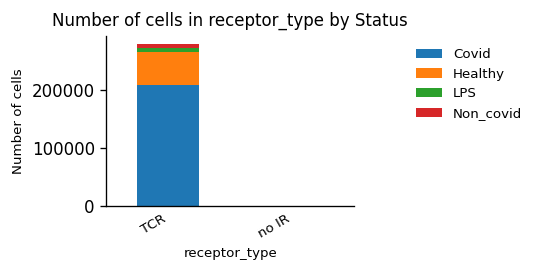

In [35]:
ir.pl.group_abundance(adata_tcr, groupby="receptor_type", target_col="Status")

<AxesSubplot:title={'center':'Number of cells in receptor_subtype by Status'}, xlabel='receptor_subtype', ylabel='Number of cells'>

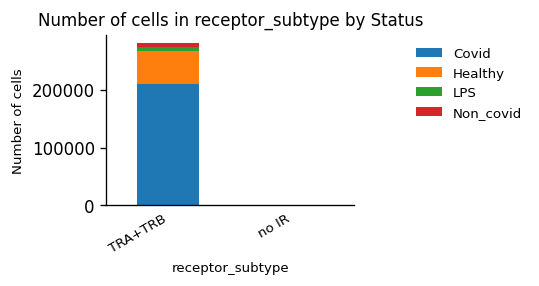

In [39]:
ir.pl.group_abundance(adata_tcr, groupby="receptor_subtype", target_col="Status")

<AxesSubplot:title={'center':'Number of cells in receptor_type by has_ir'}, xlabel='receptor_type', ylabel='Number of cells'>

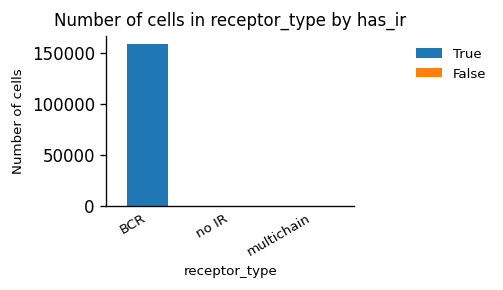

In [40]:
ir.pl.group_abundance(adata_bcr, groupby="receptor_type")

<AxesSubplot:title={'center':'Number of cells in receptor_subtype by has_ir'}, xlabel='receptor_subtype', ylabel='Number of cells'>

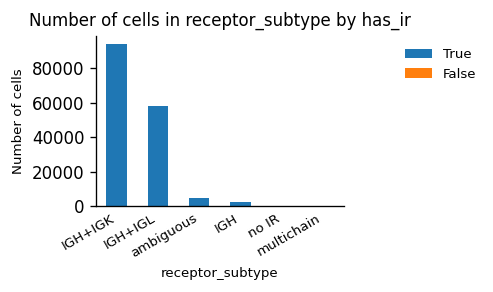

In [41]:
ir.pl.group_abundance(adata_bcr, groupby="receptor_subtype")

However, in many cases the proportion of cells per category could enmask the presence of no informative (multichain/ambigous) receptors. Therefore, check the raw numbers is an advantage in those cases.

In [22]:
adata_tcr.obs['chain_pairing'].value_counts()

single pair        196957
orphan VDJ          45266
extra VJ            19034
orphan VJ            7937
extra VDJ            7473
two full chains      3356
no IR                  22
Name: chain_pairing, dtype: int64

In [28]:
adata_bcr.obs['chain_pairing'].value_counts()

single pair        108395
orphan VJ           38301
ambiguous            4580
extra VJ             3258
orphan VDJ           2655
two full chains       999
extra VDJ             992
no IR                 261
multichain              5
Name: chain_pairing, dtype: int64

### 4.1. Mark Single Chains

Generally, not each cell is assigned a full IR (VJ and VDJ pair)

<AxesSubplot:title={'center':'Number of cells in chain_pairing by Status'}, xlabel='chain_pairing', ylabel='Number of cells'>

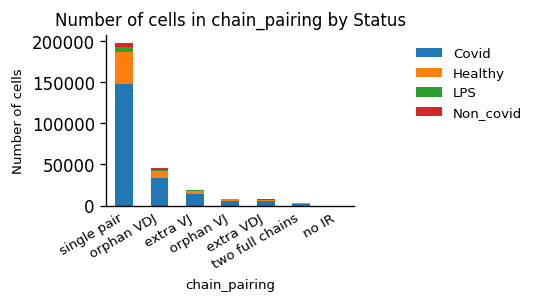

In [42]:
ir.pl.group_abundance(adata_tcr, groupby="chain_pairing", target_col="Status")

<AxesSubplot:title={'center':'Number of cells in chain_pairing by has_ir'}, xlabel='chain_pairing', ylabel='Number of cells'>

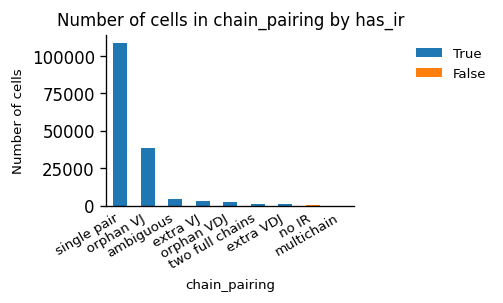

In [43]:
ir.pl.group_abundance(adata_bcr, groupby="chain_pairing")

In [63]:
adata_tcr.obs['chain_pairing'][(adata_tcr.obs['chain_pairing'] == 'orphan VDJ') | (adata_tcr.obs['chain_pairing'] == 'orphan VJ')].value_counts()

orphan VDJ         45266
orphan VJ           7937
extra VDJ              0
extra VJ               0
no IR                  0
single pair            0
two full chains        0
Name: chain_pairing, dtype: int64

In [70]:
adata_bcr.obs['chain_pairing'][(adata_bcr.obs['chain_pairing'] == 'orphan VDJ') | (adata_bcr.obs['chain_pairing'] == 'orphan VJ') | (adata_bcr.obs['chain_pairing'] == 'ambiguous')].value_counts()

ambiguous          4580
extra VDJ             0
extra VJ              0
multichain            0
no IR                 0
single pair           0
two full chains       0
Name: chain_pairing, dtype: int64

We can exclude them for further analysis, and replot thechainpairing to observe if it is now as expected

In [65]:
adata_tcr = adata_tcr[~adata_tcr.obs["chain_pairing"].isin(["orphan VDJ", "orphan VJ"]), :].copy()

<AxesSubplot:title={'center':'Number of cells in chain_pairing by Status'}, xlabel='chain_pairing', ylabel='Number of cells'>

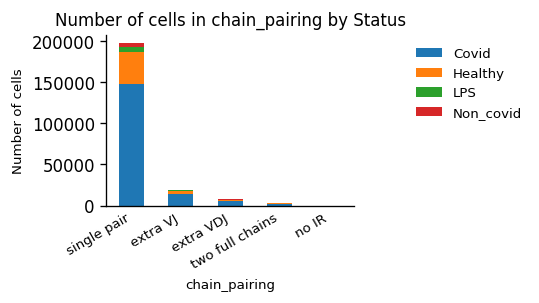

In [67]:
ir.pl.group_abundance(adata_tcr, groupby="chain_pairing", target_col="Status")

In [71]:
adata_bcr = adata_bcr[~adata_bcr.obs["chain_pairing"].isin(["orphan VDJ", "orphan VJ","ambiguous"]), :].copy()

<AxesSubplot:title={'center':'Number of cells in chain_pairing by has_ir'}, xlabel='chain_pairing', ylabel='Number of cells'>

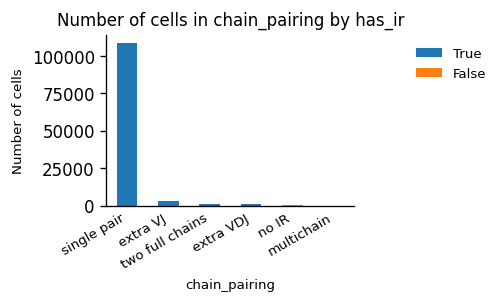

In [72]:
ir.pl.group_abundance(adata_bcr, groupby="chain_pairing")

### 4.2. Multi-Chains

Cells with more than 2 IR pairs are most likely dublets. Instead of sorting them out now, we will simply flag them and keep them in the dataset to use them as a marker later on. => we can also remove this dublet then from rna.
However, amount of multi chains should be reasonable (X%) high amount of multi chains can indicate poor quality of the readouts.

<AxesSubplot:title={'center':'Number of cells in multi_chain by Status'}, xlabel='multi_chain', ylabel='Number of cells'>

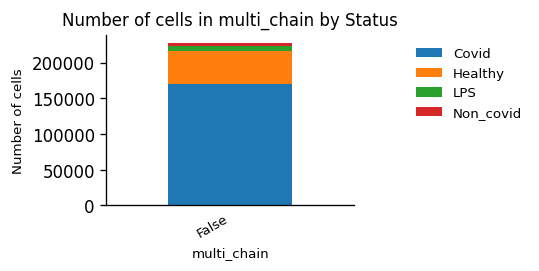

In [74]:
ir.pl.group_abundance(adata_tcr, groupby="multi_chain", target_col="Status")

<AxesSubplot:title={'center':'Number of cells in multi_chain by has_ir'}, xlabel='multi_chain', ylabel='Number of cells'>

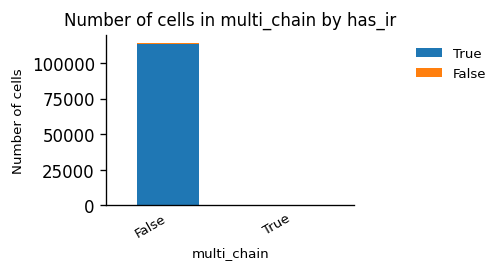

In [75]:
ir.pl.group_abundance(adata_bcr, groupby="multi_chain")

In [76]:
adata_tcr.obs['multi_chain'].value_counts()

False    226842
Name: multi_chain, dtype: int64

In [77]:
adata_bcr.obs['multi_chain'].value_counts()

False    113905
True          5
Name: multi_chain, dtype: int64

Another option as equal as orphan chains is the removal of them for further analysis. It is feasible if multichain proportion is not considerable.

In [87]:
adata_bcr = adata_bcr[adata_bcr.obs["chain_pairing"] != "multichain", :].copy()

<AxesSubplot:title={'center':'Number of cells in multi_chain by has_ir'}, xlabel='multi_chain', ylabel='Number of cells'>

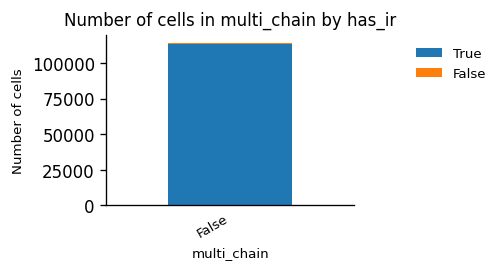

In [88]:
ir.pl.group_abundance(adata_bcr, groupby="multi_chain")

In [89]:
adata_bcr.obs['multi_chain'].value_counts()

False    113905
Name: multi_chain, dtype: int64